In [55]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib
from scipy import signal
from scipy.signal import argrelextrema
from scipy.signal import find_peaks

%pylab
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (16,12)
matplotlib.rcParams.update({'font.size': 22})
fig_num = 0

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['flag', 'floor']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


successully read acq0104.csv
0.0025


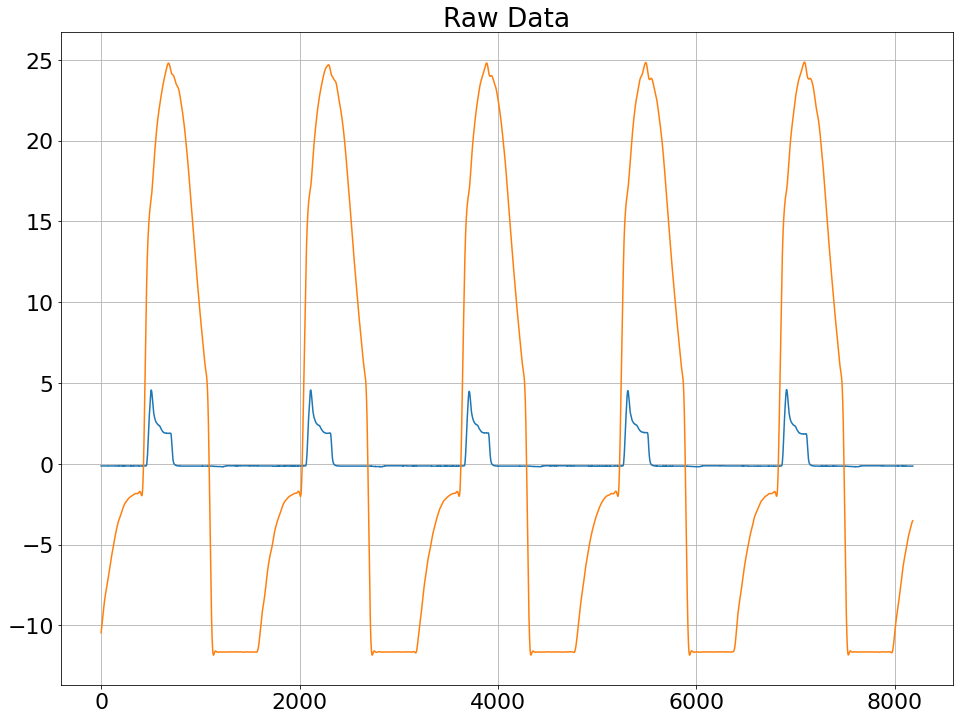

In [56]:
## Pulse Timing and Characteristics
# %reset

num = 104
name = f'acq0{num}'
extension = '.csv'
# breath_rate_name = 24
# test_case_num = 48
# duration = 0.185
# sampling_interval = 1/800
save_fig = False

filename = name + extension

#1 read the data
try:
#     data = pd.read_csv(f"pulses/{filename}",usecols = [0, 1, 3], names = ['Time','V_asl','V_pulse'], skiprows = 11)
    data = pd.read_csv(f"pulses/{filename}", names = ['Time','V_asl','V_pulse'], skiprows = 19)
    print(f"successully read {filename}")
except Exception as E:
    print("Error reading data file")
    print(E)

VDD = 5.0
data.Time = data.Time - data.Time[0]

data['Vol_pulse'] = (data.V_pulse - 1) * 2.5
data['Vol_asl'] = 212.5 * (data.V_asl/VDD - 0.1) - 10

# data.Vol_asl.plot(x = data.Time)

#filter the asl signal
# b, a = signal.butter(2, 0.01)
sos = signal.butter(4, 0.05, output='sos')
data['Vol_asl_filt'] = signal.sosfiltfilt(sos, data.Vol_asl)

original_len = len(data.Time)
# display(data)

fig_num += 1
figure(fig_num)
title('Raw Data')
plt.plot(data.Vol_pulse)
plt.plot(data.Vol_asl_filt)
grid(1)

summary = pd.read_csv("pulses/tc_summary.csv")

duration = summary.loc[summary['filenum'] == num]['Pulse Duration'].to_numpy()[0]
sampling_interval = summary.loc[summary['filenum'] == num]['samp_int'].to_numpy()[0]
breath_rate_name = summary.loc[summary['filenum'] == num]['BR'].to_numpy()[0]
test_case_num = summary.loc[summary['filenum'] == num]['TC'].to_numpy()[0]     
patient_profile = summary.loc[summary['filenum'] == num]['Patient'].to_numpy()[0]

print(sampling_interval)

# data.to_csv(name+"_"+str(test_case_num)+extension)

In [57]:
# check = input("Do you need to clip the data [y/n]?")
# print(len(data.Vol_pulse))

# if check == 'y':
#     front_clip = int(input("Provide index of front of data clip"))
#     end_clip = int(input("Provide index of end of data clip"))
    
#     if end_clip == -1:
#         end_clip = len(data.Vol_pulse) 

#     front_clip_list = np.arange(0,front_clip)
#     end_clip_list = np.arange(end_clip,len(data.Vol_pulse))
#     clip_list = np.append(front_clip_list, end_clip_list)

#     data_temp = data.drop(clip_list).reset_index(drop = True)
# #     data_temp.Index = data_temp.Index - front_clip
# #     print(data_temp)
    
#     data = data_temp
    
#     fig_num += 1
#     figure(fig_num)
#     plt.plot(data.Vol_pulse)
#     plt.plot(data.Vol_asl_filt)
#     grid(1)

-5.837512753470256
[99, 1697, 3297, 4898, 6498, 8098]
[1100, 2700, 4300, 5901, 7501]
falling [1100, 2700, 4300, 5901, 7501, 0]
7661


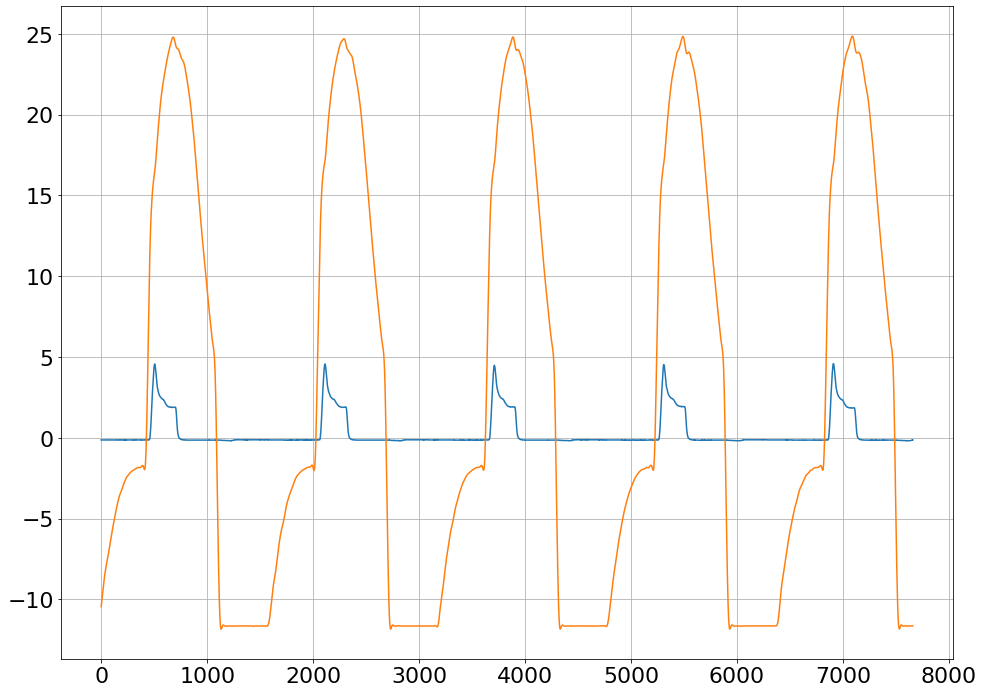

In [58]:
floor = 0.5*min(data.Vol_asl)
print(floor)

front_clip = 0
end_clip = 0

rising = []
falling = [] 
for i in np.arange(0,len(data.Vol_asl)-1):
    if (data.Vol_asl[i] < floor) and (data.Vol_asl[i+1] > floor):
        rising.append(i)
    if (data.Vol_asl[i] > floor) and (data.Vol_asl[i+1] < floor):
        falling.append(i)
        
print(rising)
print(falling)
        
front_offset = int((rising[-1] - rising[-2])/10)

if falling[0] < rising[0]:
    rising = [0] + rising
    print('rising',rising)
if falling[-1] < rising[-1]:
    falling = falling + [0]
    print('falling',falling)

if rising[0] == 0:
    front_clip = rising[1] - front_offset
    print(front_clip)
if falling[-1] == 0:
    end_clip = falling[-2] + front_offset
    print(end_clip)
    
if end_clip == 0:
    end_clip = len(data.Vol_asl)
    
front_clip_list = np.arange(0,front_clip)
end_clip_list = np.arange(end_clip,len(data.Vol_pulse))
clip_list = np.append(front_clip_list, end_clip_list)

data_temp = data.drop(clip_list).reset_index(drop = True)
# data_temp = data.drop(clip_list)
#     data_temp.Index = data_temp.Index - front_clip
#     print(data_temp)

data = data_temp

new_len = len(data.Time)

fig_num += 1
figure(fig_num)
plt.plot(data.Vol_pulse)
plt.plot(data.Vol_asl_filt)
grid(1)

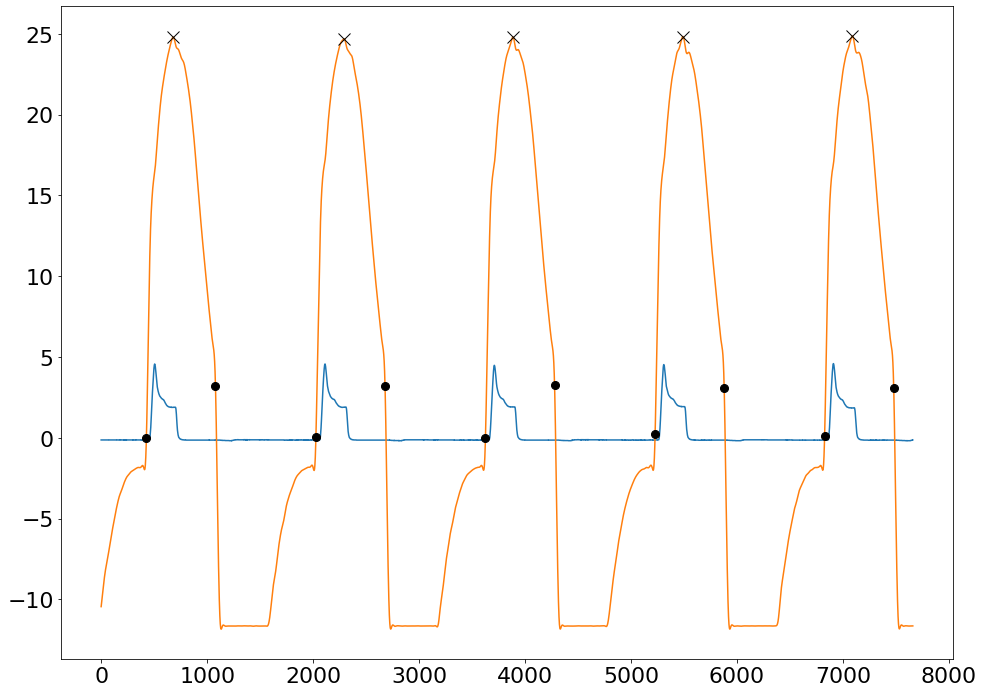

In [59]:
#determine the "number of breaths" by peak finding
peaks, _ = find_peaks(data.Vol_asl_filt, height=max(data.Vol_asl_filt)*0.7, distance = 750)
start_breath = []

#compute the start of the breaths
# back = 275
for i in peaks:
    cnt = 0
    flag = False
    while flag == False:
        cnt += 1
        if (data.Vol_asl_filt[i-cnt] > 0) and (data.Vol_asl_filt[i-cnt-1] <= 0):
            start_breath.append(i - cnt)
            flag = True

# gt_edges, _ , ASL_pos, ASL_neg = streaming_edge_detection(data.Vol_asl_filt, 5, 5, True)
# start_breath_edge = ASL_pos

# print(start_breath_edge)

#compute when breath ends
end_insp = []
window_size = 10
for j in peaks:
    cnt = 0
    flag = False
    while flag == False:
        cnt += 1
        if (data.Vol_asl_filt[j+cnt+window_size] < 0) and (data.Vol_asl_filt[j+cnt] > 0):
            end_insp.append(j+cnt)
            flag = True

#compute the volume of the breaths
volume_breath = []
for k in np.arange(0,len(start_breath)):
    volume_temp = 0
    for l in np.arange(start_breath[k]+1,end_insp[k]):
        h = (data.Time[l] - data.Time[l-1]) 
        b = ((data.Vol_asl_filt[l] + data.Vol_asl[l-1])/2)/60
        volume_temp = volume_temp + h * b
    volume_breath.append(volume_temp)

#compute the 60% of the inspired volume line
vol_oi = [] 
for k in np.arange(0,len(start_breath)):
    volume_temp = 0
    for l in np.arange(start_breath[k]+1,end_insp[k]):
        h = (data.Time[l] - data.Time[l-1]) 
        b = ((data.Vol_asl_filt[l] + data.Vol_asl[l-1])/2)/60
        volume_temp = volume_temp + h * b
        if volume_temp > volume_breath[k]*0.6:
            vol_oi.append(l)
            break

# print(vol_oi)

fig_num += 1
figure(fig_num)
plt.plot(data.Vol_pulse)
plt.plot(data.Vol_asl_filt)
plt.plot(peaks, data.Vol_asl_filt[peaks], "x", color = 'k', markersize=12)
plt.plot(start_breath, data.Vol_asl_filt[start_breath], "o", color = 'k', markersize=8)
# plt.plot(start_breath_edge, data.Vol_asl_filt[start_breath_edge], "o", color = 'b', markersize=5)
plt.plot(end_insp, data.Vol_asl_filt[end_insp], "o", color = 'k', markersize=8)

5
[456, 2063, 3662, 5262, 6862]
[505, 2112, 3712, 5311, 6910]


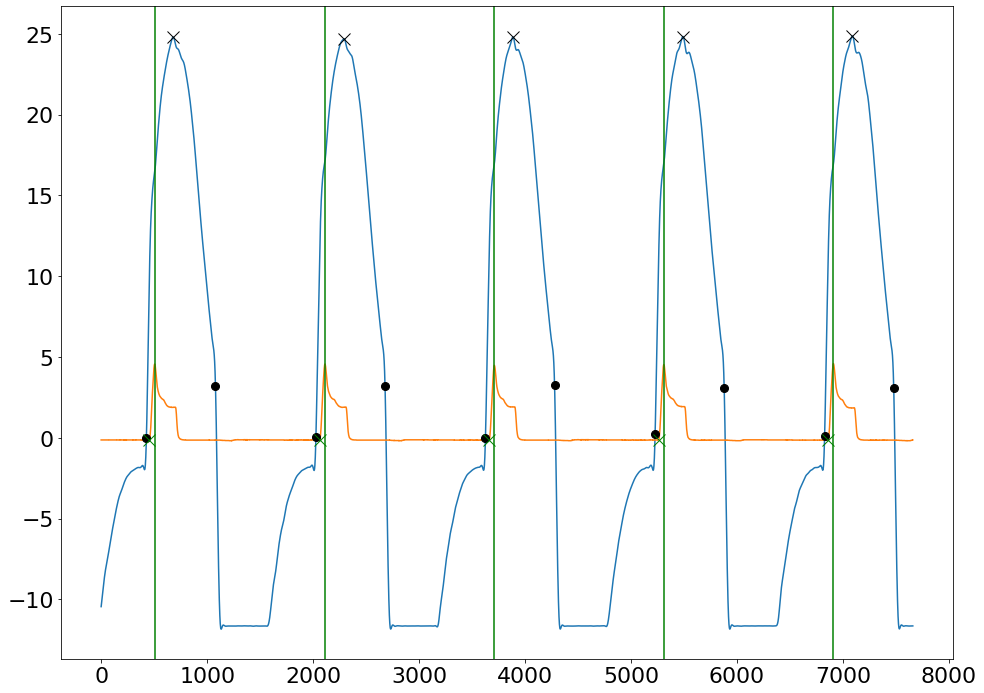

In [60]:
# sos2 = signal.butter(3, 0.8, output='sos')
# gt_edges, _ , pulse_pos, pulse_neg = streaming_edge_detection(signal.sosfiltfilt(sos2, data.Vol_pulse)*10, 30, 100, True)
# start_pulse_edge = pulse_pos

# print(pulse_pos)

back = 250
valleys2 = []
peaks2, _ = find_peaks(data.Vol_pulse, height=max(data.Vol_pulse)*0.7, distance = 750)
print(len(peaks2))
# print(peaks2)

# for i in peaks2:
#     valley = np.where(data["Vol_pulse"].iloc[np.arange(i-back,i)] == min(data["Vol_pulse"].iloc[np.arange(i-back,i)]))[-1][-1]
#     print(valley)
#     valleys2 = valleys2 + [valley]
# #     print(data["flow_temp"].iloc[np.arange(i-back,i)])
# #     print(valleys)    
#     start_edge_index_Flow.append(int(i - (back - valley)))
#     start_edge_time_Flow.append(data.Time[int(i - (back - valley))])
# #     print(start_edge_index_Flow)
# # print("local max", data.flow_temp[argrelextrema(data.flow_temp, np.greater)[0]])

start_edge_index_Flow = []
start_edge_time_Flow = []
pulse_thresh = 0.01
for i in peaks2:
    cnt = 0
    flag = False
    while flag == False:
        cnt += 1
        if (data.Vol_pulse[i-cnt] - data.Vol_pulse[i-cnt-5] <= pulse_thresh) and (data.Vol_pulse[i-cnt] < 0.1*max(data.Vol_pulse)):
            start_edge_index_Flow.append(i - cnt)
            flag = True
        
#determine where priming has ended
priming_volume = 4.3 / 1000 #L
priming_index = []
priming_time = []
for j in np.arange(len(start_edge_index_Flow)):
    i = start_edge_index_Flow[j]
    volume_temp = 0
    cnt = 1
    if j < len(start_edge_index_Flow)-1:
        if i+cnt < start_edge_index_Flow[j+1]:
            while volume_temp <= priming_volume:
                if (i+cnt) < len(data.Vol_pulse):
                    h = (data.Time[i+cnt] - data.Time[i+cnt-1]) 
                    b = ((data.Vol_pulse[i+cnt] + data.Vol_pulse[i+cnt-1])/2)/60
                    volume_temp = volume_temp + h * b
                    cnt += 1
            priming_index.append(i+cnt)
            priming_time.append(data.Time[i+cnt])
    elif j == len(start_edge_index_Flow)-1:
        if i+cnt < len(data.Vol_pulse):
            while volume_temp <= priming_volume:
                if (i+cnt) < len(data.Vol_pulse):
                    h = (data.Time[i+cnt] - data.Time[i+cnt-1]) 
                    b = ((data.Vol_pulse[i+cnt] + data.Vol_pulse[i+cnt-1])/2)/60
                    volume_temp = volume_temp + h * b
                    cnt += 1
            priming_index.append(i+cnt)
            priming_time.append(data.Time[i+cnt])
            
print(start_edge_index_Flow)
print(priming_index)

fig_num += 1
figure(fig_num)
# plt.plot(data.Vol_pulse)
plt.plot(data.Vol_asl_filt)
plt.plot(data.Vol_pulse)
plt.plot(peaks, data.Vol_asl_filt[peaks], "x", color = 'k', markersize=12)
plt.plot(start_breath, data.Vol_asl_filt[start_breath], "o", color = 'k', markersize=8)
plt.plot(end_insp, data.Vol_asl_filt[end_insp], "o", color = 'k', markersize=8)
plt.plot(start_edge_index_Flow, data.Vol_pulse[start_edge_index_Flow], "x", color = 'g', markersize=12)
# plt.plot(peaks2, data.Vol_pulse[peaks2], "x")
for i in priming_index:
    axvline(x = i, color = 'green')

In [61]:
print(len(data.Time))
ones_vect = np.ones(len(priming_index))
pulse_duration = duration * ones_vect

pulse_end_index = []
# for i in priming_index:
#     pulse_end_index.append(i+pulse_offset)
    
breath_duration = []
for i in np.arange(0,len(priming_index)):
    pulse_end_index.append(int(priming_index[i] + pulse_duration[i]/sampling_interval))
#     pulse_end_index.append(int(priming_index[i] + pulse_duration[i]/sampling_interval*new_len/original_len))
    breath_duration.append((end_insp[i] - start_breath[i])*sampling_interval)
#     ((priming_index[i] + pulse_duration[i]/sampling_interval) - vol_oi[i])*sampling_interval)

print(priming_index)
print(start_breath)
print(pulse_end_index)
print(breath_duration)

#
Insp_vol_end_pulse = []
Insp_vol_end_pulse_pct = [] 
onset_delay = []
voi_norm_to_breath_duration = []
for k in np.arange(0,len(start_breath)):
    volume_temp = 0
    for l in np.arange(start_breath[k]+1,pulse_end_index[k]):
        h = (data.Time[l] - data.Time[l-1]) 
        b = ((data.Vol_asl_filt[l] + data.Vol_asl[l-1])/2)/60
        volume_temp = volume_temp + h * b
    Insp_vol_end_pulse.append(volume_temp)
    Insp_vol_end_pulse_pct.append(round(volume_temp/volume_breath[k]*100,2))
    onset_delay.append((priming_index[k]-start_breath[k])*sampling_interval)
    voi_norm_to_breath_duration.append(((vol_oi[k]-start_breath[k])/(end_insp[k] - start_breath[k]))*100)

print(voi_norm_to_breath_duration)
print(np.array(pulse_end_index) - np.array(priming_index))

7661
[505, 2112, 3712, 5311, 6910]
[427, 2027, 3627, 5228, 6828]
[720, 2327, 3927, 5526, 7125]
[1.6300000000000001, 1.6300000000000001, 1.6300000000000001, 1.6300000000000001, 1.6300000000000001]
[52.45398773006135, 52.45398773006135, 52.45398773006135, 52.30061349693251, 52.45398773006135]
[215 215 215 215 215]


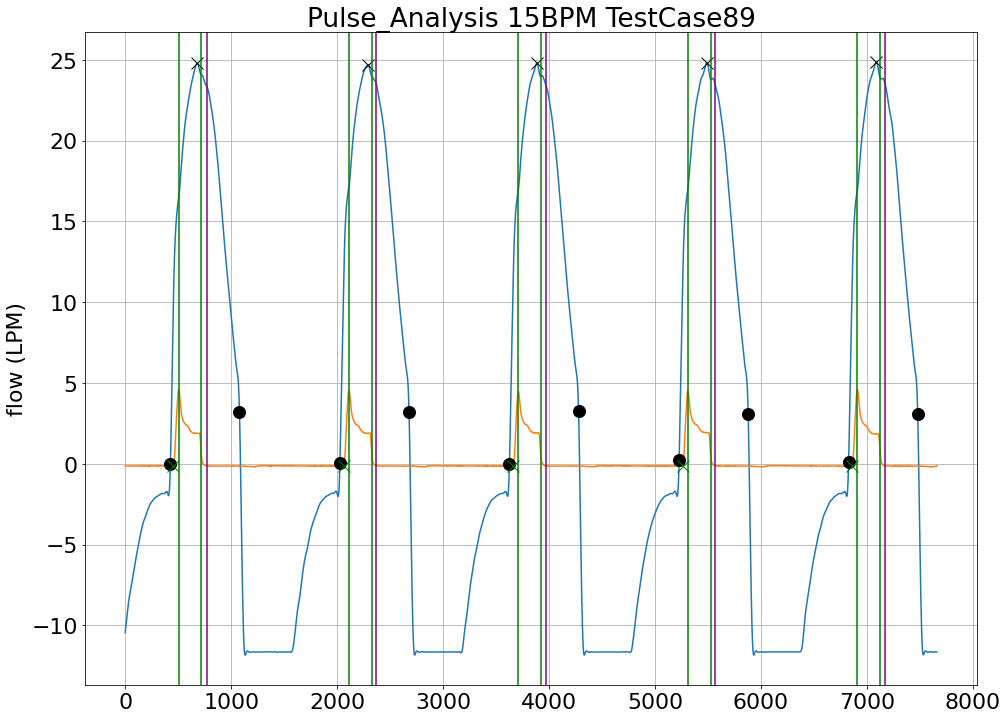

In [62]:
fig_num += 1
figure(fig_num)
# plt.plot(data.Vol_pulse)
plt.plot(data.Vol_asl_filt)
plt.plot(data.Vol_pulse)
plt.plot(peaks, data.Vol_asl_filt[peaks], "x", color = 'k', markersize=12)
plt.plot(start_breath, data.Vol_asl_filt[start_breath], "o", color = 'k', markersize=12)
plt.plot(end_insp, data.Vol_asl_filt[end_insp], "o", color = 'k', markersize=12)
plt.plot(start_edge_index_Flow, data.Vol_pulse[start_edge_index_Flow], "x", color = 'g', markersize=12)
for i in priming_index:
    axvline(x = i, color = 'green')
for i in pulse_end_index:
    axvline(x = i, color = 'green')
# plt.plot(priming_index, data.Vol_pulse[priming_index], "o", color = 'g', markersize=12)
for i in vol_oi:
    axvline(x = i, color = 'purple')
# plt.plot(vol_oi, data.Vol_asl_filt[vol_oi], "o")
grid(True)
title(f"Pulse_Analysis {breath_rate_name}BPM TestCase{test_case_num}")
ylabel("flow (LPM)")

if save_fig == True:
    savefig(f"Pulse_Analysis_{breath_rate_name}BPM_TestCase{test_case_num}")

In [63]:
timing_req = []
duration_req = []
detection_req = []
print("filenum", num)
print("TC", test_case_num)
print("BR", breath_rate_name)
print("Patient", patient_profile)
print("Pulse Duration", duration)

print("Number of Breaths Detected")
print(len(volume_breath))
print()

print('Breath Volume Per Pulse')
print(volume_breath)
print()

print("Inspired Vol at End of Pulse", Insp_vol_end_pulse)
print("Inspired Vol at Pulse End Percent", Insp_vol_end_pulse_pct)
print("Mean Inspired Vol at Pulse End Percent", round(np.mean(Insp_vol_end_pulse_pct),1))
# print("onset delay", onset_delay)
print("T_60%/T_insp", np.mean(voi_norm_to_breath_duration))
print("Mean T_insp:", round(np.mean(breath_duration),4))
print("Mean Onset Delay",round(np.mean(onset_delay),3))
print()

pulse_too_long = []
vol_insp_pcnt = []
if len(priming_index) == len(pulse_end_index):
    for i in np.arange(0,len(priming_index)):
        if (priming_index[i] > start_breath[i]) and (pulse_end_index[i] <= vol_oi[i]):
            timing_req.append(1)
        elif (priming_index[i] < vol_oi[i]) and (pulse_end_index[i] > vol_oi[i]):
            pulse_too_long.append(round(((pulse_end_index[i] - vol_oi[i])*sampling_interval* 1000),2))
            print("Pulse too long by:",round(((pulse_end_index[i] - vol_oi[i])*sampling_interval* 1000),2))
            timing_req.append(0)
        else:
            timing_req.append(0)
        
        volume_temp = 0 
        for j in np.arange(priming_index[i], pulse_end_index[i]-1):
            h = (data.Time[j+1] - data.Time[j]) 
            b = ((data.Vol_asl_filt[j+1] + data.Vol_asl_filt[j])/2)/60
            volume_temp = volume_temp + h * b
        
        print("Volume Inspired during Delivered Pulse:", round(volume_temp, 3))
        print("Volume Inspired during Pulse as percent of Tv:", round(100*volume_temp/volume_breath[i],3))
        vol_insp_pcnt.append(round(100*volume_temp/volume_breath[i],3))
#         print(0.3*volume_breath[i])
        print("Tv:", round(volume_breath[i],3))
        print()
        
        if volume_temp >= 0.3*volume_breath[i]:
            duration_req.append(1)
        else:
            duration_req.append(0)
            
        if (priming_index[i] > start_breath[i]) and (pulse_end_index[i] < end_insp[i]):
            detection_req.append(1)
        else:
            detection_req.append(0)
            
print('Timing Requirement; 0 is miss, 1 is hit')     
print(timing_req)
print(sum(timing_req)/len(timing_req) * 100,"%")
print('Duration Requirement; 0 is miss, 1 is hit')   
print(duration_req)
print(sum(duration_req)/len(duration_req) * 100,"%")
print('Detection Requirement; 0 is miss, 1 is hit')   
print(detection_req)
print(sum(detection_req)/len(detection_req) * 100,"%")
print()
print("Mean Volume Inspired during Pulse as percent of Tv:", round(np.mean(vol_insp_pcnt),2))
print()

if len(pulse_too_long) > 0:
    print("Mean Pulse too long by",np.mean(pulse_too_long))
    print("Mean Pulse too long by normalized to pulse duration",round((np.mean(pulse_too_long)/1000)/duration*100,1))
    print("Mean Pulse too long by normalized to breath duration",round((np.mean(pulse_too_long)/1000)/np.mean(breath_duration)*100,1))

filenum 104
TC 89
BR 15
Patient ILD LS2
Pulse Duration 0.539
Number of Breaths Detected
5

Breath Volume Per Pulse
[0.4711890730460281, 0.47107411815528566, 0.47114223941033645, 0.47127097944546714, 0.4711307661332202]

Inspired Vol at End of Pulse [0.23364741680758028, 0.2406769413363514, 0.24028718085219983, 0.2392933230459551, 0.23798894881470722]
Inspired Vol at Pulse End Percent [49.59, 51.09, 51.0, 50.78, 50.51]
Mean Inspired Vol at Pulse End Percent 50.6
T_60%/T_insp 52.42331288343557
Mean T_insp: 1.63
Mean Onset Delay 0.206

Volume Inspired during Delivered Pulse: 0.198
Volume Inspired during Pulse as percent of Tv: 42.052
Tv: 0.471

Volume Inspired during Delivered Pulse: 0.201
Volume Inspired during Pulse as percent of Tv: 42.588
Tv: 0.471

Volume Inspired during Delivered Pulse: 0.2
Volume Inspired during Pulse as percent of Tv: 42.532
Tv: 0.471

Volume Inspired during Delivered Pulse: 0.2
Volume Inspired during Pulse as percent of Tv: 42.464
Tv: 0.471

Volume Inspired durin